#### Resumen previo:
Trato de hacer lo mismo que "1DP1_1" pero ahora con una solución fisicamente conocida, Schwarzschild

## Parte dos: Schwarzschild unidimensional

In [1]:
Atom = false
#Atom = true

false

In [2]:
using Gridap
using GridapODEs
if  !Atom
    using GridapMakie, GLMakie
end
using FileIO
using GridapGmsh
using gmsh

In [3]:
L = 40.
model = GmshDiscreteModel("modelos/1D40.msh")

Info    : Reading 'modelos/1D40.msh'...
Info    : 3 entities
Info    : 1497 nodes
Info    : 1498 elements
Info    : Done reading 'modelos/1D40.msh'


UnstructuredDiscreteModel()

In [4]:
Ω = Triangulation(model)
degree = 3
dΩ = Measure(Ω,degree)

Measure()

In [5]:
if Atom == false 
    fig, ax = plot(Ω)
    wireframe!(Ω, color=:black, linewidth=2)
    fig
end

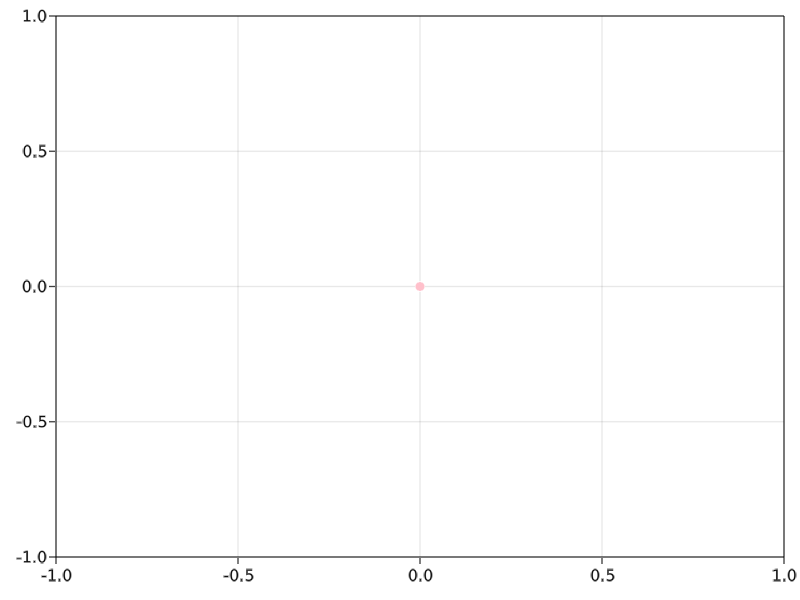

In [7]:
neumanntags_L=["center"] #["L"]
Γ_L = BoundaryTriangulation(model,tags=neumanntags_L)
dΓ_L = Measure(Γ_L,degree)
if Atom == false 
    fig = plot(Γ_L, linewidth=8
    #, shading=true
    )
end

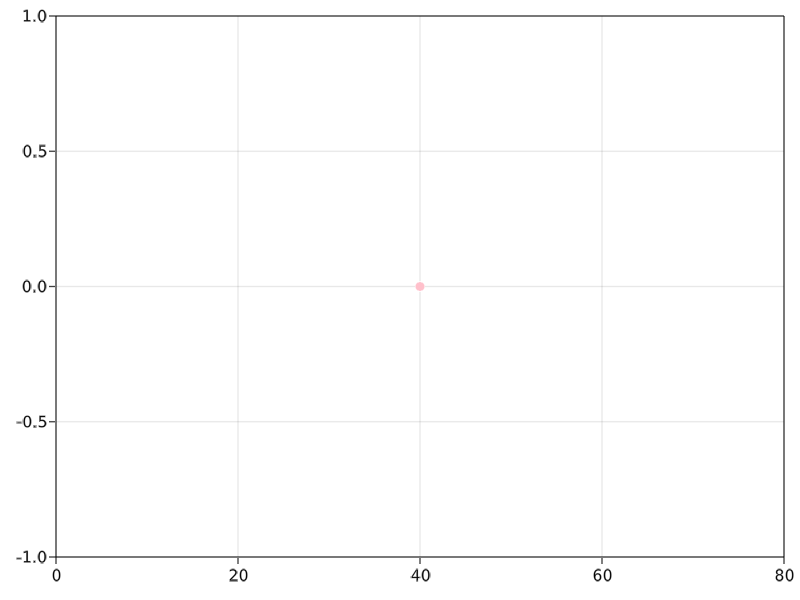

In [8]:
neumanntags_R= ["ext"] #["R"]
Γ_R = BoundaryTriangulation(model,tags=neumanntags_R)
dΓ_R = Measure(Γ_R,degree)
if Atom == false 
    fig = plot(Γ_R, linewidth=8
    #, shading=true
    )
end

In [9]:
order = 2
reffe = ReferenceFE(lagrangian,Float64,order)
V = TestFESpace(model,reffe,conformity=:H1)
U = TrialFESpace(V)

UnconstrainedFESpace()

In [10]:
R=20.
M=R/2. 
aa=12. *R^2 -20. *R^10 -8. *R^6
bb=-18. * R^5 +6. *R -22. *R^9 +2. *R^13
cc=2. -22. *R^4 -18. *R^8 +6* R^12
A= ((2. *(R^4 +1.)*(1. +M/(2. *R) +(M/(4. *R))*(1. +R^4))/(R^3 *(R^4 -1.)) )*(cc *R -bb) -cc *(1. +M/(2. *R))*(1. +R^4)/R^2 +M*((1. +R^4)^4) /R^3 )/(aa+(bb -cc *R)* 2. *R/(R^4 -1.) -cc *R^2)# (1+R^3)*(1. +M/(2. *R) +(M*(1. +R^3))/(2. *R *(2. -3. *R^2)) )/(R^3 *(3. / (2. -3. *R^2) -1.))

0.9999572915190971

In [11]:
B=  2. *A*R/(R^4 -1.)+ 2. *(R^4 +1.)*(1. +M/(2. *R) +(M/(4. *R))*(1. +R^4))/(R^3 *(R^4 -1.)) #(1. +M/(2. *R))*(1. +R^3)/R^2 -A *R

5.000656245572852

In [12]:
C=(1. +M/(2. *R))*(1. +R^4)/(R^2)-A*R^2 -B *R

0.007083480904171324

In [13]:
s(x) = x[1]/ R 

function ψ_p(x)
    if s(x)  < 1.0
        return (A * x[1]^4 +B * x[1]^3 +C *x[1]^2)/(1. +x[1]^4 )
        end
    if s(x) >= 1.0
       return  (1. + M/(2. *x[1]))
    end
end

ψ_p (generic function with 1 method)

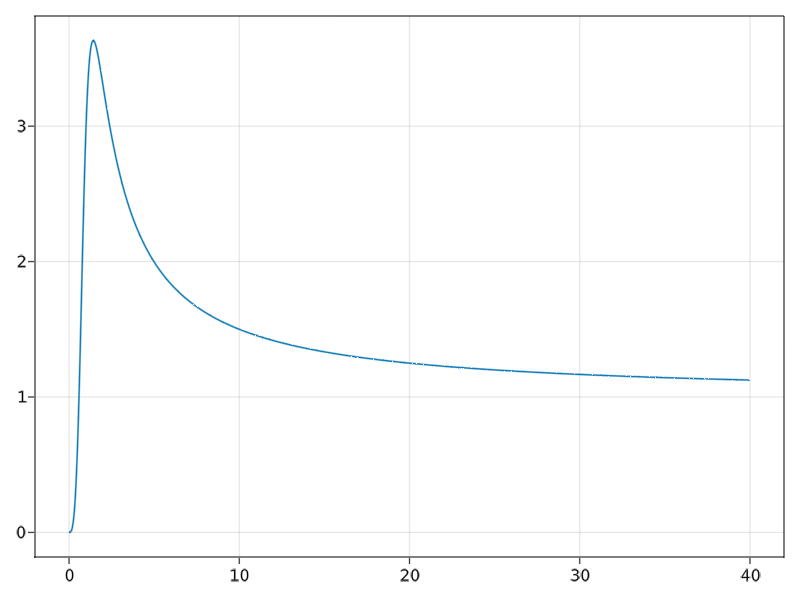

In [14]:
x = range(0., L, length=100000)
lines(x,ψ_p, label= "exact") 

In [15]:
function dρ_ρψ_p(x)
    if s(x)  < 1.0
        return ( (-7. *B *x[1]^6 - 12. *C *x[1]^5+16. *A *x[1]^3+9. *B *x[1]^2 +4. *C *x[1] )*(1. +x[1]^4 )^2 -8. *x[1]^3 *(1. +x[1]^4 ) *(-B *x[1]^7 - 2. *C *x[1]^6+4. *A *x[1]^4+3. *B *x[1]^3 +2. *C *x[1]^2 ) )/(1. +x[1]^4 )^4
        end
    if s(x) >= 1.0
       return   M/(2. *x[1]^2)
    end
end

α(x)= -(ψ_p(x)) ^3 * dρ_ρψ_p(x) /(2. *π*x[1]^2)

α (generic function with 1 method)

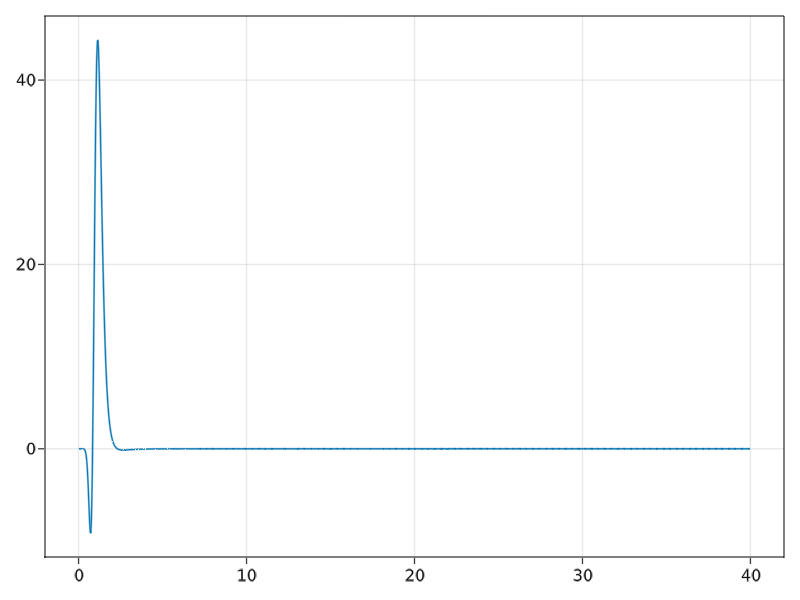

In [16]:
x = range(0., L, length=100000)
lines(x,α, label= "exact") 

In [17]:
function t1(x)
    return 2. * π*α(x)
end

function t2(x)
  return 6. * π*α(x)
end

t2 (generic function with 1 method)

In [18]:
ρ(x)=x[1]
ρvec(x) = VectorValue(1.)

ρvec (generic function with 1 method)

In [19]:
c(x)=0

c (generic function with 1 method)

In [20]:
res0(w,w2)=  ∫(  - (∇(w2) ⋅ ∇(w))*ρ  + t1*( (w2*ρ * ρ)/(w*w*w))  )*dΩ +∫( -w2 *(w- 1.))*dΓ_R +∫( c * w2 *ρ )*dΓ_L

res0 (generic function with 1 method)

In [21]:
jac0(w,dw,w2)= ∫(  - ( ∇(w2) ⋅ ∇(dw))*ρ   - t2 *((dw* w2*ρ * ρ)/(w*w*w*w)) )*dΩ   +∫( -w2 *dw  )*dΓ_R

jac0 (generic function with 1 method)

In [22]:
oppsi0 = FEOperator(res0,jac0,U,V)

FEOperatorFromWeakForm()

In [23]:
using LineSearches: BackTracking
nls = NLSolver(
  show_trace=true, method=:newton, linesearch=BackTracking(),ftol=1E-15, xtol= 1E-20)
solver = FESolver(nls)

NonlinearFESolver()

In [24]:
w020=interpolate_everywhere(ψ_p,U)

SingleFieldFEFunction():
 num_cells: 1496
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 7995118389938228269

In [25]:
w0, = solve!(w020,solver,oppsi0)

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.184504e-05              NaN
     1     3.126283e-05     4.653430e-10
     2     2.813655e-05     1.381254e-08
     3     2.719609e-05     1.191298e-09
     4     2.447648e-05     9.937917e-09
     5     2.445968e-05     1.596220e-12
     6     2.421508e-05     1.323494e-10
     7     2.374139e-05     2.948169e-10
     8     2.350398e-05     1.402140e-10
     9     2.294776e-05     4.070291e-10
    10     2.289039e-05     4.291885e-11
    11     2.226293e-05     5.186553e-10
    12     2.221423e-05     1.283338e-11
    13     1.999280e-05     7.167421e-09
    14     1.979288e-05     5.336284e-11
    15     1.969391e-05     5.113706e-11
    16     1.772452e-05     5.093458e-09
    17     5.363998e-06     4.337248e-07
    18     5.360616e-06     3.954071e-13
    19     5.360075e-06     2.273912e-13
    20     5.359993e-06     1.026801e-14
    21     5.359967e-06     3.173911e-15
    22     5.35995

(SingleFieldFEFunction(), NLSolversCache())

In [26]:
x = range(0., L, length=1000)
lines(x, evaluate(w0 ,Gridap.Point.(x)), label= "u")

In [27]:
dif_cuad= (w0 -ψ_p)*(w0 -ψ_p)

OperationCellField():
 num_cells: 1496
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 7995118389938228269

In [28]:
L2norm_dif_cuad= sqrt(sum( ∫( dif_cuad)*dΩ ))

0.00012451373750921776

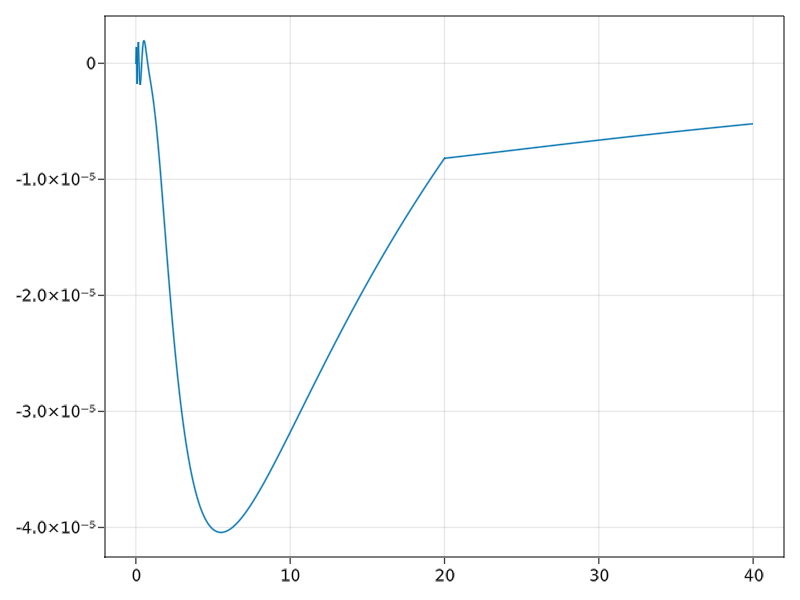

In [29]:
x = range(0., L, length=1000)
lines(x, evaluate(w0 -ψ_p,Gridap.Point.(x)), label= "u")